In [0]:
# Import necessary libraries
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Download Kitti Road Dataset

In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
!unzip data_road.zip    

--2020-04-21 17:23:45--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.235
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470992343 (449M) [application/zip]
Saving to: ‘data_road.zip’

data_road.zip       100%[===================>] 449.17M  21.4MB/s    in 22s     

2020-04-21 17:24:08 (20.5 MB/s) - ‘data_road.zip’ saved [470992343/470992343]

Archive:  data_road.zip
   creating: data_road/
   creating: data_road/training/
   creating: data_road/testing/
   creating: data_road/training/image_2/
  inflating: data_road/training/image_2/umm_000032.png  
  inflating: data_road/training/image_2/umm_000031.png  
  inflating: data_road/training/image_2/umm_000030.png  
  inflating: data_road/training/image_2/umm_000029.png  
  inflating: data_road/training/image_2/umm_000028.png 

In [3]:
import os
os.listdir('data_road/training')

['image_2', 'calib', 'gt_image_2']

# Visualise the raw dataset

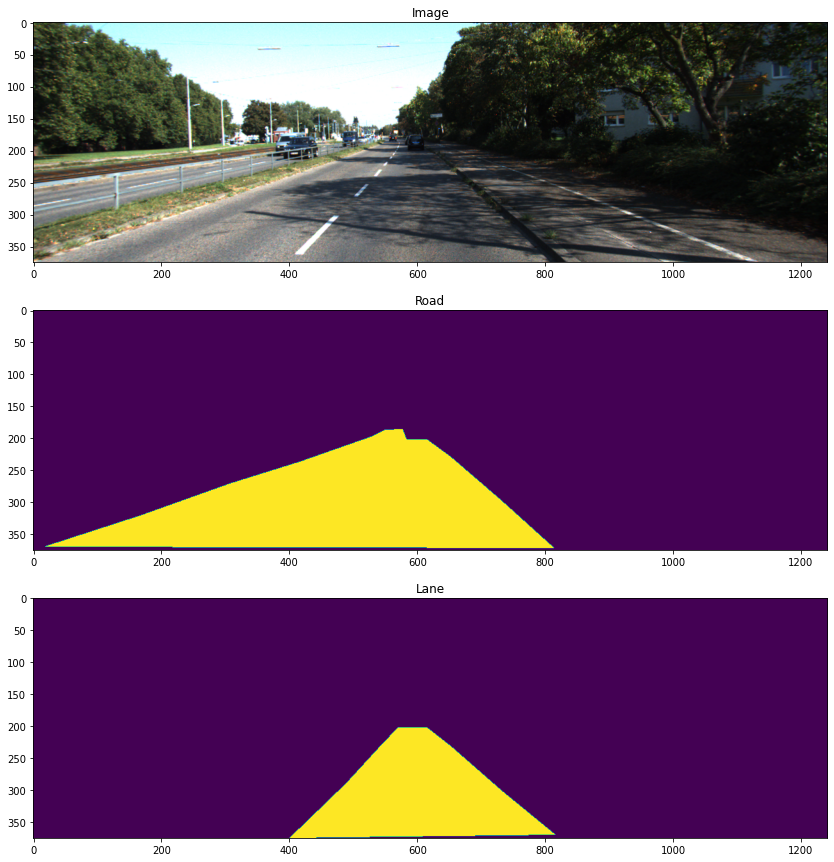

In [4]:
import matplotlib.image as mpimg

plt.figure(figsize=(45,15))

plt.subplot(3,1,1)
plt.imshow(mpimg.imread('data_road/training/image_2/um_000015.png'))
plt.title("Image")

plt.subplot(3,1,2)
plt.imshow(mpimg.imread('data_road/training/gt_image_2/um_road_000015.png')[:,:,2])
plt.title("Road")

plt.subplot(3,1,3)
plt.imshow(mpimg.imread('data_road/training/gt_image_2/um_lane_000015.png')[:,:,2])
plt.title("Lane")

plt.show()

## Class to create dataset

In [0]:
class generate_dataset(Dataset):
    
    def __init__(self,root_dir):
        self.image_filenames = []
        self.mask_filenames = []
        
        for filename in os.listdir(os.path.join(root_dir , 'image_2')):
            self.image_filenames.append(os.path.join(os.path.join(root_dir , 'image_2'), filename))
            
        for filename in os.listdir(os.path.join(root_dir , 'gt_image_2')):
            if filename.startswith('um_road') or filename.startswith('uu_road') or filename.startswith('umm_road'):
                self.mask_filenames.append(os.path.join(os.path.join(root_dir , 'gt_image_2'), filename))    
                
        self.image_filenames.sort()
        self.mask_filenames.sort()
        
        self.image_transform = transforms.Compose([
            transforms.Resize(size=(160, 576)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
        self.mask_transform = transforms.Compose([
            transforms.Resize(size=(160, 576)),
            transforms.ToTensor()
        ])
        
    # You must override __getitem__ and __len__
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self,index):
        image = Image.open(self.image_filenames[index])
        mask = Image.open(self.mask_filenames[index])
        image = self.image_transform(image)
        mask = self.mask_transform(mask)
        # select only the 3rd channel (index = 2) along dim = 0 (channel)
        mask = torch.index_select(mask, 0, torch.tensor([2]))
        
        return image, mask  

## Split the dataset into train and valid dataset

In [6]:
train_dataset = generate_dataset('data_road/training')  

# split the dataset into validation and test sets
len_valid_set = int(0.1*len(train_dataset))
new_len_train_set = len(train_dataset) - len_valid_set

print("The length of Train set is {}".format(new_len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset = torch.utils.data.random_split(train_dataset , [new_len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True)

The length of Train set is 261
The length of Valid set is 28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 160, 576])
tensor(2.5354) tensor(-2.1179)


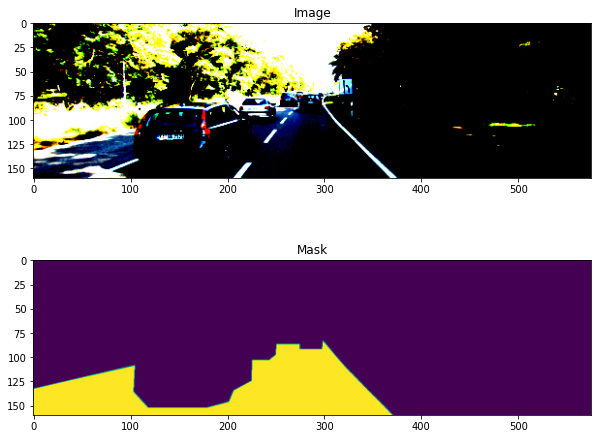

In [10]:
image, mask = train_dataset[0]

print(mask.shape)
print(torch.max(image), torch.min(image))

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.imshow(image.numpy().transpose(1,2,0))
plt.title('Image')

plt.subplot(2,1,2)
plt.imshow(mask.squeeze().numpy())
plt.title('Mask')

plt.show()

## Create UNET Network

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    '''Initial Conv'''
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    '''Downsampling Block'''
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    '''Upsampling Block'''
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
 
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2, diffY // 2, diffY - diffY//2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1x1 conv
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)

In [0]:
# 3 input channels and 1 output channel
network = UNet(3,1)
network.cuda()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

# Function to overwrite the console output

In [0]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

## Loss Function

In [0]:
def dice_loss(pred_mask, true_mask):
    # variant of IOU
    pred_mask = pred_mask.view(-1)
    true_mask = true_mask.view(-1)
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum()
    return 1 - ((2.0 * intersection + 1.0) / (union + 1.0))

def IOU(pred_mask, true_mask):
    # variant of IOU
    pred_mask = pred_mask.view(-1).detach()
    true_mask = true_mask.view(-1)
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum() - intersection
    iou = (intersection + 1.0) / (union + 1.0)
    return iou

def binarize(mask):
    ones = torch.ones(mask.shape).cuda()
    zeros = torch.zeros(mask.shape).cuda()
    binary_mask = torch.where(mask > 0.5, ones, zeros)
    return binary_mask.cuda()

## Training

In [0]:
num_epochs = 100

# define the optimizer
# only weights of fc layer has to be updated
optimizer = optim.Adam(network.parameters(), lr=0.0001)

# note the starting time to find the total time elapsed
start_time = time.time()

# minimum loss = infinity
loss_min = np.inf

for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    # set the network into train mode
    network.train()
    
    for step in range(1,len(train_loader)+1):
    
        images, masks = next(iter(train_loader))
        
        # move the images and masks to GPU
        images = images.cuda()
        masks = masks.cuda()
        logits = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = dice_loss(logits, binarize(masks))
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    # turn the gradients off for validation
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, masks = next(iter(valid_loader))

            # move the images and masks to GPU
            images = images.cuda()
            masks = masks.cuda()

            logits = network(images)

            # find the loss and acc for the current step
            loss_valid_step = dice_loss(logits, binarize(masks))

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/kitti.pth') 
        print("\nMinimum validation loss of {} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
    
# find the time at the end of training    
end_time = time.time()

print('Training Complete')
print("Total time taken : {} s".format(end_time - start_time))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Valid Steps: 4/4  Loss: 0.1101 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0966  Valid Loss: 0.1101
--------------------------------------------------

Minimum validation loss of 0.11011084914207458 at epoch 1/100
Model Saved

Valid Steps: 4/4  Loss: 0.1236 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0875  Valid Loss: 0.1236
--------------------------------------------------
Valid Steps: 4/4  Loss: 0.1244 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0898  Valid Loss: 0.1244
--------------------------------------------------
Valid Steps: 4/4  Loss: 0.1430 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0759  Valid Loss: 0.1430
--------------------------------------------------
Valid Steps: 4/4  Loss: 0.1216 
--------------------------------------------------
Epoch: 5  Train Loss: 0.0783  Valid Loss: 0.1216
--------------------------------------------------
Valid Ste

KeyboardInterrupt: ignored

## Load the best model

In [0]:
best_network = UNet(3,1)
best_network.cuda()
best_network.load_state_dict(torch.load('/kitti.pth')) 
best_network.eval()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

In [0]:
def denormalize(image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view([1,3,1,1]).cuda()
    std = torch.tensor([0.229, 0.224, 0.225]).view([1,3,1,1]).cuda() 
    
    image = image * std + mean
    return image

## Test the Network

In [0]:
def test_model(model):
    
    start_time = time.time()

    with torch.no_grad():
        images, masks = next(iter(valid_loader))
            
        images = images.cuda()
        masks = masks.cuda()
        logits = model(images)
        
        images = denormalize(images)
        
        plt.figure(figsize=(20,40))
        
        for img_num in range(8):
            plt.subplot(8,1,img_num+1)
            plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0))
            plt.imshow(binarize(logits[img_num]).cpu().squeeze().numpy(), alpha=0.3)

    print('Total number of test images: {}'.format(len(valid_dataset)))

    end_time = time.time()
    print("Elapsed Time : {}".format(end_time - start_time))
    
test_model(best_network)    

Output hidden; open in https://colab.research.google.com to view.